In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bertopic

In [3]:
def read_N_merge(path1, path2):
    columns = ['authorName', 'createdAt', 'message']
    df1 = pd.read_csv(path1)[columns]
    df1['createdAt'] = pd.to_datetime(df1['createdAt'])
    
    df2 = pd.read_csv(path2)[columns]
    df2['createdAt'] = pd.to_datetime(df2['createdAt'])
    
    df = pd.concat([df1, df2])
    df = df.sort_values(by=['createdAt'])
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    
    return df

In [4]:
companies = ['aapl', 'abb', 'amzn', 'aon', 'bmy', 'cern', 'csco', 'ebay', 'hsbc', 'jpm', 'mmm', 'nflx', 'pypl']

In [5]:
def merge_chats(dfs):
    for (name, df) in dfs: 
        df['Comp'] = name
    new_df = pd.concat([dfs[i][1] for i in range(len(dfs))])
    
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns = ['index'])
    return new_df
 

In [6]:
my_dfs = []
for comp in companies:
    df_merged = read_N_merge('Yahoo/'+comp+'_msg.csv', 'Yahoo/'+comp+'_reply.csv')
    my_dfs.append((comp, df_merged))

full_corpus = merge_chats(my_dfs)

In [7]:
full_corpus

,authorName,createdAt,message,Comp
0,Charlie,2017-04-21 14:56:59,FoxNews expected to pay around $85 mil to sett...,aapl
1,Drmicrocap,2017-08-02 09:01:54,https://drmicrocap.blogspot.com/2017/08/apple-...,aapl
2,Cfa,2017-11-01 06:10:40,$AAPL $AMZN $GOOG $BABA $MSFT $FB $NFLX $NVDA ...,aapl
3,None,2017-12-05 09:48:31,Selling after a few years (since 2010 at 45). ...,aapl
4,Fuel,2018-04-20 22:27:58,"Guys, I just nutted again. My stamina is way u...",aapl
...,...,...,...,...
169820,Tom~T,2020-12-20 22:30:06,Friday's News. Inconclusive if this Mutation /...,pypl
169821,Tom~T,2020-12-20 22:33:52,Great IF It Happens!\nI've given up on 2020 an...,pypl
169822,Tom~T,2020-12-20 22:40:10,Nah!\nUnknown! 🤪 Danger! 🤖 Danger!,pypl
169823,Claudio,2020-12-21 00:06:01,Bitcoin up again pushing new highs,pypl


##### Data Cleaning

In [2]:
import string

In [3]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

wnl = WordNetLemmatizer()

In [9]:
def find_url(text):
    regex = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    url = re.findall(regex,text)
    if url != []:
        return [x for x in url]
    else:
        return []

In [10]:
def add_url(df):
    for i in range(df.shape[0]):
        urls = []
        text = df['message'].iloc[i]
        text = re.sub('\n', '', text)
        if text == 'n':
            continue
        urls = find_url(text)
        if urls != []:
            df['URLs'][i] = ' '.join(urls)

In [11]:
import demoji
demoji.download_codes()

... OK (Got response in 0.44 seconds)
Writing emoji data to /Users/salkhalil/.demoji/codes.json ...
... OK


In [2]:
' '.isspace()

True

In [12]:
def remove_emoji(text):
    return demoji.replace(text)

In [13]:
def clean_data(text):
    text = str(text)
    text = remove_emoji(text)
    # Stemming / Tokenisation
    tokens = word_tokenize(text)
    tokens = [wnl.lemmatize(t) for t in tokens]
    text = ' '.join(tokens)
    text = text.lower()
    
    url_regex = regex = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    unwanted_punc = string.punctuation.replace("$", "")
    unwanted_punc = unwanted_punc.replace("#", "")
    
    text = text.replace("\n", " ")
    text = re.sub(url_regex, '', text)
    text = re.sub('\w*\d\w*', '', text) # removes numbers
    text = re.sub('[%s]' % re.escape(unwanted_punc), ' ', text) # removes punctuation
    if text = '' or text.isspace():
        return 'n'
    return text

cleanD = lambda x: clean_data(x)

In [14]:
def clean(df):
    df['URLs'] = None
    df['message'] =df['message'].fillna("n")
    add_url(df)
    df['msg_clean'] = df.message.apply(cleanD)

In [15]:
clean(full_corpus)

<ipython-input-10-89be22d1bd5c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['URLs'][i] = ' '.join(urls)


In [16]:
full_corpus

,authorName,createdAt,message,Comp,URLs,msg_clean
0,Charlie,2017-04-21 14:56:59,FoxNews expected to pay around $85 mil to sett...,aapl,None,foxnews expected to pay around $ mil to settl...
1,Drmicrocap,2017-08-02 09:01:54,https://drmicrocap.blogspot.com/2017/08/apple-...,aapl,https://drmicrocap.blogspot.com/2017/08/apple-...,http drmicrocap blogspot com apple repor...
2,Cfa,2017-11-01 06:10:40,$AAPL $AMZN $GOOG $BABA $MSFT $FB $NFLX $NVDA ...,aapl,None,$ aapl $ amzn $ goog $ baba $ msft $ fb $ nflx...
3,None,2017-12-05 09:48:31,Selling after a few years (since 2010 at 45). ...,aapl,None,selling after a few year since at it j...
4,Fuel,2018-04-20 22:27:58,"Guys, I just nutted again. My stamina is way u...",aapl,None,guys i just nutted again my stamen is way ...
...,...,...,...,...,...,...
169820,Tom~T,2020-12-20 22:30:06,Friday's News. Inconclusive if this Mutation /...,pypl,None,friday s news inconclusive if this mutation...
169821,Tom~T,2020-12-20 22:33:52,Great IF It Happens!\nI've given up on 2020 an...,pypl,None,great if it happens i ve given up on and d...
169822,Tom~T,2020-12-20 22:40:10,Nah!\nUnknown! 🤪 Danger! 🤖 Danger!,pypl,None,nah unknown danger danger
169823,Claudio,2020-12-21 00:06:01,Bitcoin up again pushing new highs,pypl,None,bitcoin up again pushing new high


##### Aggregate messages

In [17]:
import dateparser
import datetime
import time
from dateutil import parser

def parse_dtime(time_str):
    '''
    Parses time and date from date_msg column to time.struct_time type.
    
    Parameters:
    time_str-- string containing date-time info
    
    Returns:
    parsed_dtime-- time.struct_time object with date-time info of time_str
    '''

    parsed_dtime = time.strptime(str(time_str), '%Y-%m-%d %H:%M:%S')
    return parsed_dtime

def window_check(t1, t2, window):
    t1_sec, t2_sec = time.mktime(t1), time.mktime(t2)
    wind_sec = window*60**2
    if t2_sec - t1_sec < wind_sec and t2_sec - t1_sec > 0:
        return True
    return False

def get_time(df, ind, date_col):
    return df[date_col].iloc[ind]

def aggregate_msg_by_time(df, msg_col='message', date_col='createdAt', window = 24):
    cur_ind = 0
    
    block_msg = []
    num_msgs = []
    block_start = []
    block_end = []
    
    
    while cur_ind < df.shape[0]:
        cur_t = get_time(df, cur_ind, date_col)
        cur_block = df[msg_col].iloc[cur_ind]
        block_start.append(cur_t)
        
        j = 1
        if cur_ind+j >= df.shape[0]:
            num_msgs.append(j)
            block_msg.append(cur_block)
            block_end.append(df[date_col].iloc[cur_ind+j-1])
            break
        next_t = get_time(df, cur_ind+j, date_col)
        
        while window_check(parse_dtime(cur_t), parse_dtime(next_t), window) and cur_ind+j < df.shape[0]:
            cur_block += ' ' + str(df[msg_col].iloc[cur_ind + j])
            j += 1
            if cur_ind+j < df.shape[0]:
                next_t = get_time(df, cur_ind+j, date_col)
        
        num_msgs.append(j)
        block_msg.append(cur_block)
        block_end.append(df[date_col].iloc[cur_ind+j-1])
        
        cur_ind += j
    
    new_df_data = {'Block_msg': block_msg, 'Num_msgs': num_msgs,
                   'Start_time': block_start, 'End_time': block_end}
    
    new_df = pd.DataFrame.from_dict(new_df_data)
    
    return new_df

In [ ]:
get_time(full_corpus, 1, 'createdAt')

In [ ]:
full_data_clean_aggH = aggregate_msg_by_time(full_corpus, window=1,   msg_col='msg_clean')
full_data_clean_aggD = aggregate_msg_by_time(full_corpus, window=24,  msg_col='msg_clean')
full_data_clean_aggW = aggregate_msg_by_time(full_corpus, window=168, msg_col='msg_clean')

In [ ]:
full_data_clean_aggW

#### LDA topic modelling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
cv = CountVectorizer(stop_words= 'english', min_df = 10, max_df = 0.4, token_pattern=r'\b[a-zA-Z]{4,}\b')
dtm_cv = cv.fit_transform(full_data_clean_aggH.Block_msg) 

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda_cv = LatentDirichletAllocation(n_components=10, random_state=0)
lda_cv.fit(dtm_cv)

In [ ]:
full_dtm_cv = cv.fit_transform(full_data_clean_aggD.Block_msg) 
full_lda_cv = LatentDirichletAllocation(n_components=10, random_state=0)
full_lda_cv.fit(full_dtm_cv)

In [ ]:
full_lda_cv.components_.shape

In [ ]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def calc_coherence(lda, count_vec, df):
    a = metric_coherence_gensim(measure='c_v', 
                        top_n=20, 
                        topic_word_distrib= lda.components_, 
                        dtm = count_vec,
                        texts = [s.split(' ') for s in df.Block_msg.values.tolist()],
                        vocab = np.array([x for x in cv.vocabulary_.keys()]))

    return np.nanmean(a)

In [ ]:
a = 1;a+=1
a

In [ ]:
def tune_hyp(alphas, betas, n_tops, dfs):
    blocks = ['Hourly', 'Daily', 'Weekly']
    aLog, bLog, blockLog, topLog, scores = [], [], [], [], []
    for block in blocks:
        for top in n_tops:
            for a in alphas:
                for b in betas:
                    cur_df = dfs[block]
                    cur_dtm = cv.fit_transform(cur_df.Block_msg)
                    cur_lda = LatentDirichletAllocation(n_components=top, random_state=0, doc_topic_prior=a, topic_word_prior=b)
                    cur_lda.fit(cur_dtm)
                    cur_score = calc_coherence(cur_lda, cur_dtm, cur_df)
                    aLog.append(a); bLog.append(b); blockLog.append(block); topLog.append(top); scores.append(cur_score)
    logDict = {'Blocking': blockLog, 'Num Topics': topLog, 'Alpha': aLog, 'Beta': bLog, 'c_v': scores}
    
    return pd.DataFrame.from_dict(logDict)

In [ ]:
block_dfs = {'Weekly': full_data_clean_aggW, 'Daily': full_data_clean_aggD, 'Hourly': full_data_clean_aggH}

In [ ]:
lda_log = tune_hyp([1, 2, 5, 10],
                   [0.05, 0.1, 0.25, 0.4],
                   [10, 15, 25, 50],
                   block_dfs)

In [ ]:
lda_log.to_csv('lda_log.csv')

In [ ]:
import seaborn as sns

In [ ]:
cur_df = lda_log[(lda_log['Num Topics'] == 10) & (lda_log['Blocking'] == 'Daily')]
p = cur_df.pivot('Alpha', 'Beta', 'c_v')
sns.heatmap(p)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
3%2

In [ ]:

def plot_ab_results(df, block):
    our_df = df[df.Blocking == block]
    tops = [10, 15, 25, 50]
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    plt.subplots_adjust(hspace = 0.25, wspace=0.3)
    fig.suptitle('Alpha-Beta results for {} grouping'.format(block))
    for i in range(4):
        cur_df = our_df[our_df['Num Topics'] == tops[i]]
        cur_df = cur_df.pivot('Alpha', 'Beta', 'c_v')
        
        sns.heatmap(cur_df, ax=ax[i//2,i%2])
        ax[i//2,i%2].title.set_text('{} Tops'.format(tops[i]))
    plt.show()

In [ ]:
plot_ab_results(lda_log, 'Hourly')

In [ ]:
plot_ab_results(lda_log, 'Daily')

In [ ]:
plot_ab_results(lda_log, 'Weekly')

In [ ]:
cur_df= lda_log[lda_log['Blocking'] == 'Weekly']
cur_df= cur_df[['Num Topics', 'c_v']]
cur_df = cur_df.groupby(['Num Topics']).max()
cur_df

In [ ]:
def get_topics(model, feature_names, n):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx+1] = ', '.join([feature_names[i] for i in topic.argsort()[:-n-1:-1]])
    
    return topics

In [ ]:
weekly_appl_tops = get_topics(full_lda_cv, cv.get_feature_names(), 7)

In [ ]:
weekly_appl_tops

In [ ]:
daily_appl_tops = get_topics(full_lda_cv, cv.get_feature_names(), 7)

In [ ]:
daily_appl_tops

In [ ]:
hourly_appl_tops = get_topics(full_lda_cv, cv.get_feature_names(), 7)

In [ ]:
hourly_appl_tops

In [ ]:
full_data_clean_aggW['Num_msgs'].mean()

In [ ]:
def fit_models(dfs, keys, ntops = 10):
    cv = CountVectorizer(stop_words= 'english', min_df = 10, max_df = 0.5, token_pattern=r'\b[a-zA-Z]{4,}\b')
    all_topics = {}
    for i in range(len(dfs)):
        df = dfs[i]
        dtm_cv = cv.fit_transform(df.Block_msg) 
        lda_cv = LatentDirichletAllocation(n_components=ntops, random_state=0)
        lda_cv.fit(dtm_cv)
        this_top = get_topics(lda_cv, cv.get_feature_names(), 7)
        all_topics[keys[i]] = this_top
    return all_topics

In [ ]:
aaple_net_tops = fit_models([data_clean_aggH, data_clean_aggD, data_clean_aggW], ['Hourly', 'Daily', 'Weekly'], ntops=10)

In [ ]:
aaple_net_tops['Weekly']

In [ ]:
aaple_net_tops['Daily']

In [ ]:
aaple_net_tops['Hourly']

In [ ]:
np.mean(data_clean_aggW.Num_msgs)

#### Model Selection

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
search_params = {'n_components': [10, 15, 20, 25, 30],
                 'learning_decay': [.5, .7, .9]}

dtm_cv = cv.fit_transform(data_clean_aggW.Block_msg) 
lda = LatentDirichletAllocation(random_state=0)

model_select = GridSearchCV(lda, param_grid=search_params)
model_select.fit(dtm_cv)

In [ ]:
best_hourly_mod = model_select.best_estimator_

print("Best Model's Params: ", model_select.best_params_)
print("Best Log Likelihood Score: ", model_select.best_score_)
print("Model Perplexity: ", best_hourly_mod.perplexity(dtm_cv))

In [ ]:
best_daily_mod = model_select.best_estimator_

print("Best Model's Params: ", model_select.best_params_)
print("Best Log Likelihood Score: ", model_select.best_score_)
print("Model Perplexity: ", best_daily_mod.perplexity(dtm_cv))

In [ ]:
best_weekly_mod = model_select.best_estimator_

print("Best Model's Params: ", model_select.best_params_)
print("Best Log Likelihood Score: ", model_select.best_score_)
print("Model Perplexity: ", best_weekly_mod.perplexity(dtm_cv))

In [ ]:
n_comps = [10, 15, 20, 25, 30]


#### Visualisation of Topics

In [ ]:
dtm_hour = cv.fit_transform(data_clean_aggH.Block_msg)
lda = LatentDirichletAllocation(n_components=10)
lda.fit(dtm_hour)

In [ ]:
dtm_day = cv.fit_transform(data_clean_aggD.Block_msg)
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(dtm_day)

In [ ]:
dtm_week = cv.fit_transform(data_clean_aggW.Block_msg)
lda = LatentDirichletAllocation(n_components=10)
lda.fit(dtm_week)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
full_lda_cv.

In [ ]:
pyLDAvis.sklearn.prepare(full_lda_cv, full_dtm_cv, cv, mds='tsne')

In [ ]:
get_topics(lda, cv.get_feature_names(), 10)

In [ ]:
cv._data

In [ ]:
pyLDAvis.sklearn.prepare(lda_cv, dtm_cv, cv, mds='tsne')

In [ ]:
pyLDAvis.sklearn.prepare(lda, dtm_week, cv, mds='tsne')

#### Trying topic embeddings from Top2Vec
[paper](https://arxiv.org/abs/2008.09470)

In [ ]:
data_aggD = aggregate_msg_by_time(corpus, window=24)
data_aggH = aggregate_msg_by_time(corpus, window=1)

In [19]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = encoder.encode(data_aggH.Block_msg)

NameError: name 'data_aggH' is not defined

In [ ]:
embeddings.shape

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
encoder = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = encoder.encode(data_aggH.Block_msg)

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)



In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.2)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.2, cmap='hsv_r')
plt.colorbar()

In [ ]:
result.loc[result.labels == 6]

In [ ]:
data_aggH['Topic'] = cluster.labels_
docs_per_topic = data_aggH.groupby(['Topic'], as_index=False).agg({'Block_msg': ' '.join})

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Block_msg.values, m=len(data_aggH.Block_msg))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Block_msg
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Block_msg": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(data_aggH); topic_sizes.head(10)

In [ ]:
top_n_words[10][:10]

In [ ]:
full_corpus

redoing cleaning phase but with limited steps as they're not needed for this method

In [18]:
def clean_data_t2v(text):
    text = str(text)
    #text = remove_emoji(text)
#     text = text.lower()
    
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    
    text = text.replace("\n", " ")
    
    text = re.sub('\w*\d\w*', '', text) # removes numbers

    
    return text

cleanDt = lambda x: clean_data_t2v(x)

In [19]:
full_corpus['t2v'] = full_corpus.message.apply(cleanDt)

In [20]:
def rem_em_url(text):
    text = str(text)
    url_regex = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    text = re.sub(url_regex, '', text)
    text = remove_emoji(text)
    
    return text

rEmUrl = lambda x: rem_em_url(x)

In [21]:
full_corpus['t2v'] = full_corpus.t2v.apply(rEmUrl)

In [23]:
bTop_model = bertopic.BERTopic.load("base_hourly_noGram")
bTopNg_model = bertopic.BERTopic.load("base_hourly_grams")

In [24]:
full_data_aggH = aggregate_msg_by_time(full_corpus, window=1,   msg_col='t2v')
full_data_aggD = aggregate_msg_by_time(full_corpus, window=24,  msg_col='t2v')

In [28]:
bTop_model = bertopic.BERTopic(n_gram_range=(1,3))
topH, probH = bTop_model.fit_transform(full_data_aggH.Block_msg)

In [31]:
bTopNg_model = bertopic.BERTopic()
topHNg, probHNg = bTopNg_model.fit_transform(full_data_aggH.Block_msg)

In [28]:
bTopNg_model.get_topics()[12]

[('abb', 0.7454598857779182),
 ('abnb', 0.09300266788744115),
 ('sbux', 0.09148526569852614),
 ('bmrr', 0.05755764160880758),
 ('abbabb', 0.05755764160880758),
 ('bac', 0.05490713132502383),
 ('bldp', 0.05361930535562607),
 ('expansion', 0.030850366803168855),
 ('ba', 0.030697483547942012),
 ('opened', 0.03049983516109306)]

In [ ]:
bTop_model.visualize_distribution(probH[1536])

In [ ]:
for i in range(123):
    bTop_model.get_topic

In [ ]:
bTop_model.find_topics("trump")

In [ ]:
bTop_full = bertopic.BERTopic()
top_full, prob_full = bTop_full.fit_transform(full_corpus.t2v)

In [35]:
bTop_model.save("base_hourly_noGram")
bTopNg_model.save("base_hourly_grams")

In [31]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan

In [34]:
td = {}
a = [1,2,3]
td[1] = a
a = [1]
td[2] = a
td

{1: [1, 2, 3], 2: [1]}

In [38]:
def get_embeddings(msgs, ndims):
    encoder = SentenceTransformer('distilbert-base-nli-mean-tokens')
    print("Calculating 768d embeddings...")
    embeddings = encoder.encode(msgs)
    print("Done")
    print("Reducing dimensions...")
    u_embs = {}
    for nd in ndims:
        umap_embeddings = umap.UMAP(n_neighbors=15,
                                    n_components=nd,
                                    metric='cosine').fit_transform(embeddings)
        u_embs[nd] = umap_embeddings
    print("Done.")
    return u_embs

In [39]:
hourly_embs = get_embeddings(full_data_aggH.Block_msg, [2, 5])

Calculating 768d embeddings...
Done
Reducing dimensions...
Done.


In [209]:
def plot_t2v(embs, labels):
    result = pd.DataFrame(embs, columns=['x', 'y'])
    result['labels'] = labels

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1]
    clustered = result.loc[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.2)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.2, cmap='hsv_r')
    plt.xlim([2,15])
    plt.ylim([2,15])
    plt.colorbar()

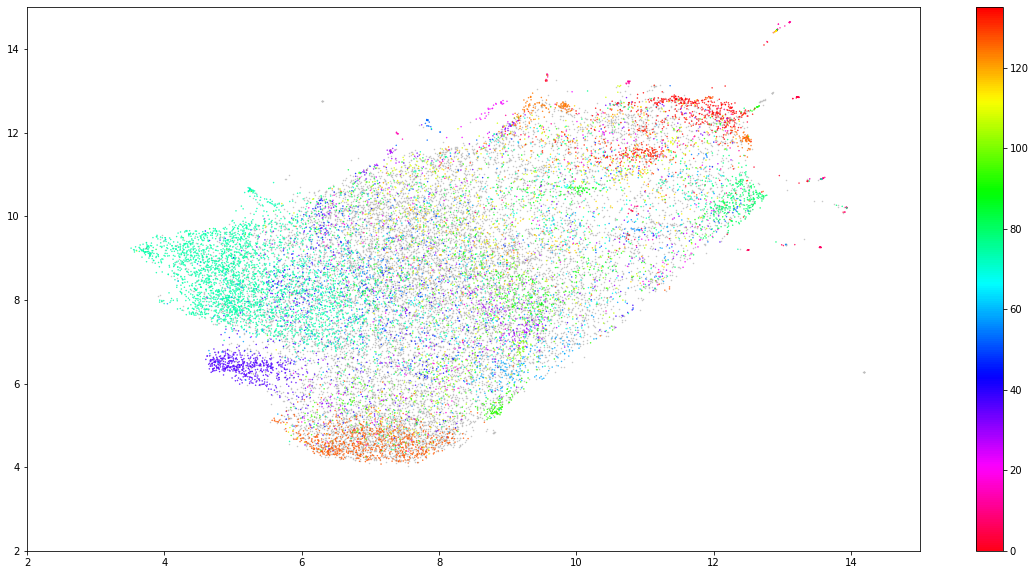

In [210]:
plot_t2v(hourly_embs[2], preds[0])

In [29]:
full_data_aggH['top_Ng'] = preds[0]

In [44]:
full_data_aggH

,Block_msg,Num_msgs,Start_time,End_time,top_Ng
0,FoxNews expected to pay around $ mil to settle...,1,2017-04-21 14:56:59,2017-04-21 14:56:59,-1
1,#aapl #Nasdaq Composite #S& Index #Dow Jones,1,2017-08-02 09:01:54,2017-08-02 09:01:54,-1
2,$AAPL $AMZN $GOOG $BABA $MSFT $FB $NFLX $NVDA ...,1,2017-11-01 06:10:40,2017-11-01 06:10:40,-1
3,Selling after a few years (since at ). It jus...,1,2017-12-05 09:48:31,2017-12-05 09:48:31,113
4,"Guys, I just nutted again. My stamina is way u...",1,2018-04-20 22:27:58,2018-04-20 22:27:58,36
...,...,...,...,...,...
25083,Following bank stocks now. Crazy but good Up ...,2,2020-12-20 01:30:42,2020-12-20 01:31:33,-1
25084,New Covid mutation in England So interesting ...,1,2020-12-20 21:13:03,2020-12-20 21:13:03,-1
25085,Friday's News. Inconclusive if this Mutation /...,3,2020-12-20 22:30:06,2020-12-20 22:40:10,-1
25086,Bitcoin up again pushing new highs,1,2020-12-21 00:06:01,2020-12-21 00:06:01,-1


In [213]:
ng_tws

{-1: ['get',
  'people',
  'buy',
  'can',
  'stock',
  'go',
  'when',
  'biden',
  'would',
  'why'],
 0: ['mkt', 'junk', 'than'],
 1: [],
 2: ['hk',
  'down',
  'low',
  'kung',
  'ching',
  'weak',
  'garbage',
  'bottom',
  'china',
  'short'],
 3: ['hk', 'low', 'dip', 'never'],
 4: ['blockchain'],
 5: ['hsbc',
  'hsbcpa',
  'julien',
  'british',
  'rbc',
  'dvd',
  'chip',
  'paying',
  'blue',
  'bank'],
 6: ['hsbc',
  'hsbcpa',
  'low',
  'down',
  'boycotthsbc',
  'bottomed',
  'silent',
  'boycott',
  'lows',
  'nope'],
 7: ['hsbc', 'hsbcpa'],
 8: ['abb'],
 9: ['down', 'downsizing'],
 10: ['cern'],
 11: ['aon',
  'high',
  'nepotism',
  'eastern',
  'open',
  'exciting',
  'alert',
  'er',
  'growth',
  'coming'],
 12: ['abb',
  'abnb',
  'sbux',
  'bmrr',
  'abbabb',
  'bac',
  'bldp',
  'expansion',
  'ba',
  'opened'],
 13: ['cern', 'cerner', 'carnac', 'making', 'aapl', 'buy'],
 14: ['breakdown',
  'sweet',
  'premarket',
  'short',
  'jan',
  'fleeced',
  'smartypants',


In [67]:
hourly_embs.shape

(25088, 5)

In [58]:
def calculate_top_vecs(ntops, df, embeddings, top_col = 'top_Ng'):
    emb_dim = embeddings.shape[1]
    top_vecs = np.zeros((ntops-1, emb_dim))
    for top in range(ntops-1):
        inds = df.loc[df[top_col] == top].index
        t_vec = np.zeros(emb_dim)
        for ind in inds:
            t_vec += embeddings[ind, :]
        t_vec /= len(inds)
        top_vecs[top, :] = t_vec
    return top_vecs

In [59]:
t_vecs_Ng = calculate_top_vecs(len(bTopNg_model.get_topics()), full_data_aggH, hourly_embs[5])

In [63]:
t_vecs_Ng2d = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        metric='cosine').fit_transform(t_vecs_Ng)

In [80]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
import pickle

In [82]:
with open('t_vecsNg.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([t_vecs_Ng, t_vecs_Ng2d], f)

with open('hourly_embs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(hourly_embs, f)

In [83]:
plot_tops(t_vecs_Ng2d, ng_tws)

In [74]:
def plot_tops(tvs, tv_dt):
    df = pd.DataFrame(tvs, columns=['x', 'y'])
    df['words'] = [', '.join(tv_dt[i]) for i in tv_dt.keys() if i != -1]
    fig = px.scatter(df, x="x", y="y", text="words", log_x=True, size_max=60)

    fig.update_traces(textposition='top center')

    fig.update_layout(
        height=800,
        title_text='GDP and Life Expectancy (Americas, 2007)'
    )

    fig.show()


In [76]:
msg_embs = get_embeddings(full_corpus.t2v, 5)

Calculating 768d embeddings...
Done
Reducing dimensions...
Done.


In [31]:
import csv

In [71]:
def dict_from_gt(gt):
    out_dict = {}
    keys = gt.keys()
    for k in keys:
        tuples = gt[k]
        out_dict[k] = [t[0] for t in tuples if t[1] > 0.001]

    return out_dict

ng_tws = dict_from_gt(bTopNg_model.get_topics())
g_tws = dict_from_gt(bTop_model.get_topics())

In [44]:
def write_tws(t_dict, fn):
    with open(fn, 'w') as f:
        writer = csv.DictWriter(f, fieldnames=['Topic', 'Words'])
        writer.writeheader()
        for k in t_dict.keys():
            f.write('{}, {}\n'.format(str(k), ', '.join(t_dict[k])))
        f.close()

In [46]:
write_tws(ng_tws, 'topic_words_noGram.csv')
write_tws(g_tws, 'topic_words_wGram.csv')

In [85]:
[bTopNg_model.get_topic(i) for i in ng_tws.keys() if len(ng_tws[i]) <= 3]

[[('mkt', 0.08579281027576496),
  ('junk', 0.0610787164660895),
  ('than', 0.022353144588047196),
  ('formulation', 0.0),
  ('formulas', 0.0),
  ('formularies', 0.0),
  ('formimg', 0.0),
  ('formwhisperscom', 0.0),
  ('formented', 0.0),
  ('formatwatch', 0.0)],
 [('formulating', 0.0),
  ('formulas', 0.0),
  ('formulary', 0.0),
  ('formularies', 0.0),
  ('forming', 0.0),
  ('formimg', 0.0),
  ('formatchange', 0.0),
  ('formasking', 0.0),
  ('formented', 0.0),
  ('formatwatch', 0.0)],
 [('blockchain', 0.9665312062939705),
  ('formwhispers', 0.0),
  ('formulas', 0.0),
  ('formwhisperscom', 0.0),
  ('zzzzzzzzzzzzz', 0.0),
  ('formented', 0.0),
  ('formatwatch', 0.0),
  ('formathello', 0.0),
  ('formatchange', 0.0),
  ('format', 0.0)],
 [('hsbc', 0.9156784681847989),
  ('hsbcpa', 0.07573566042906045),
  ('formulary', 0.0),
  ('formularies', 0.0),
  ('zzzzzzzzzzzzz', 0.0),
  ('formulas', 0.0),
  ('formwhispers', 0.0),
  ('formwhisperscom', 0.0),
  ('formimg', 0.0),
  ('formatwatch', 0.0)],
 

In [49]:
from itertools import product
from difflib import SequenceMatcher

In [90]:
t1 = [1,2,3]
t2 = [4,5,6]

for a, b in list(product(t1, t2)):
    print(a, b)

1 4
1 5
1 6
2 4
2 5
2 6
3 4
3 5
3 6


In [47]:
def check_top_merge(top_dict, t):
    keys = top_dict.keys()
    out = []
    for i in keys:
        words_i = top_dict[i]
        if words_i == []:
            continue
        for j in keys:
            if j <= i:
                continue
            words_j = top_dict[j]
            if words_j == []:
                continue
            score = 0
            for p in list(product(words_i, words_j)):
                score += SequenceMatcher(None, p[0], p[1]).ratio()
            score /= len(list(product(words_i, words_j)))
            if score >= t:
                out.append((i, j))
    return out

In [50]:
check_top_merge(ng_tws, 0.35)

[(5, 7), (8, 12), (10, 11), (10, 13)]

In [55]:
def predict_topNg(text, t):
    pred, prob = bTopNg_model.find_topics(text)
    tops = [pred[i] for i in range(len(pred)) if prob[i] >= t]
    if tops == []:
        return 'n'
    return ', '.join(str(tops))

In [56]:
pred_tNg  = lambda x: predict_topNg(x, 0.3)

In [ ]:
full_corpus['top_Ng'] = full_corpus['t2v'].apply(pred_tNg)

In [1]:
full_corpus.to_csv('full_corpus.csv')

NameError: name 'full_corpus' is not defined

In [26]:
print('hi')

hi


In [25]:
preds = bTopNg_model.transform(full_data_aggH.Block_msg)

In [107]:
full_corpus['top_Ng'] = -2

In [109]:
tops, probs = bTopNg_model.transform(full_corpus.loc[full_corpus.Comp == 'pypl'].t2v.values)

In [123]:
inds = full_corpus.loc[full_corpus.Comp == 'pypl'].index.values
full_corpus.at[inds, 'top_Ng'] = tops

In [130]:
ng_tws[16]

['dip',
 'dips',
 'plug',
 'goog',
 'marshmallows',
 'suckonthat',
 'worrylololol',
 'gooo',
 'subtitles',
 'rips']

In [132]:
full_corpus.iloc[15].createdAt

Timestamp('2019-05-02 17:39:38')

##### Off-Topic
We now try and plot some off topic things

In [105]:
pypl_embs = get_embeddings(full_corpus.loc[full_corpus.Comp == 'pypl'].t2v.values, [2, 5])

Calculating 768d embeddings...
Done
Reducing dimensions...
Done.


In [137]:
np.zeros(3)

array([0., 0., 0.])

In [144]:
dev_pypl = calc_devation(full_corpus, 'pypl', pypl_embs[5])

In [145]:
full_corpus['deviation'] = 0

In [146]:
full_corpus.at[inds, 'deviation'] = dev_pypl

In [148]:
full_corpus

,authorName,createdAt,message,Comp,URLs,msg_clean,t2v,top_Ng,deviation
0,Charlie,2017-04-21 14:56:59,FoxNews expected to pay around $85 mil to sett...,aapl,None,foxnews expected to pay around $ mil to settl...,FoxNews expected to pay around $ mil to settle...,-2,0.000000
1,Drmicrocap,2017-08-02 09:01:54,https://drmicrocap.blogspot.com/2017/08/apple-...,aapl,https://drmicrocap.blogspot.com/2017/08/apple-...,http drmicrocap blogspot com apple repor...,#aapl #Nasdaq Composite #S& Index #Dow Jones,-2,0.000000
2,Cfa,2017-11-01 06:10:40,$AAPL $AMZN $GOOG $BABA $MSFT $FB $NFLX $NVDA ...,aapl,None,$ aapl $ amzn $ goog $ baba $ msft $ fb $ nflx...,$AAPL $AMZN $GOOG $BABA $MSFT $FB $NFLX $NVDA ...,-2,0.000000
3,None,2017-12-05 09:48:31,Selling after a few years (since 2010 at 45). ...,aapl,None,selling after a few year since at it j...,Selling after a few years (since at ). It jus...,-2,0.000000
4,Fuel,2018-04-20 22:27:58,"Guys, I just nutted again. My stamina is way u...",aapl,None,guys i just nutted again my stamen is way ...,"Guys, I just nutted again. My stamina is way u...",-2,0.000000
...,...,...,...,...,...,...,...,...,...
169820,Tom~T,2020-12-20 22:30:06,Friday's News. Inconclusive if this Mutation /...,pypl,None,friday s news inconclusive if this mutation...,Friday's News. Inconclusive if this Mutation /...,-1,-0.060233
169821,Tom~T,2020-12-20 22:33:52,Great IF It Happens!\nI've given up on 2020 an...,pypl,None,great if it happens i ve given up on and d...,Great IF It Happens! I've given up on and don...,70,0.281354
169822,Tom~T,2020-12-20 22:40:10,Nah!\nUnknown! 🤪 Danger! 🤖 Danger!,pypl,None,nah unknown danger danger,Nah! Unknown! Danger! Danger!,80,0.262881
169823,Claudio,2020-12-21 00:06:01,Bitcoin up again pushing new highs,pypl,None,bitcoin up again pushing new high,Bitcoin up again pushing new highs,-1,0.757306


<AxesSubplot:title={'center':'Paypal Topic Deviation plot'}, xlabel='createdAt'>

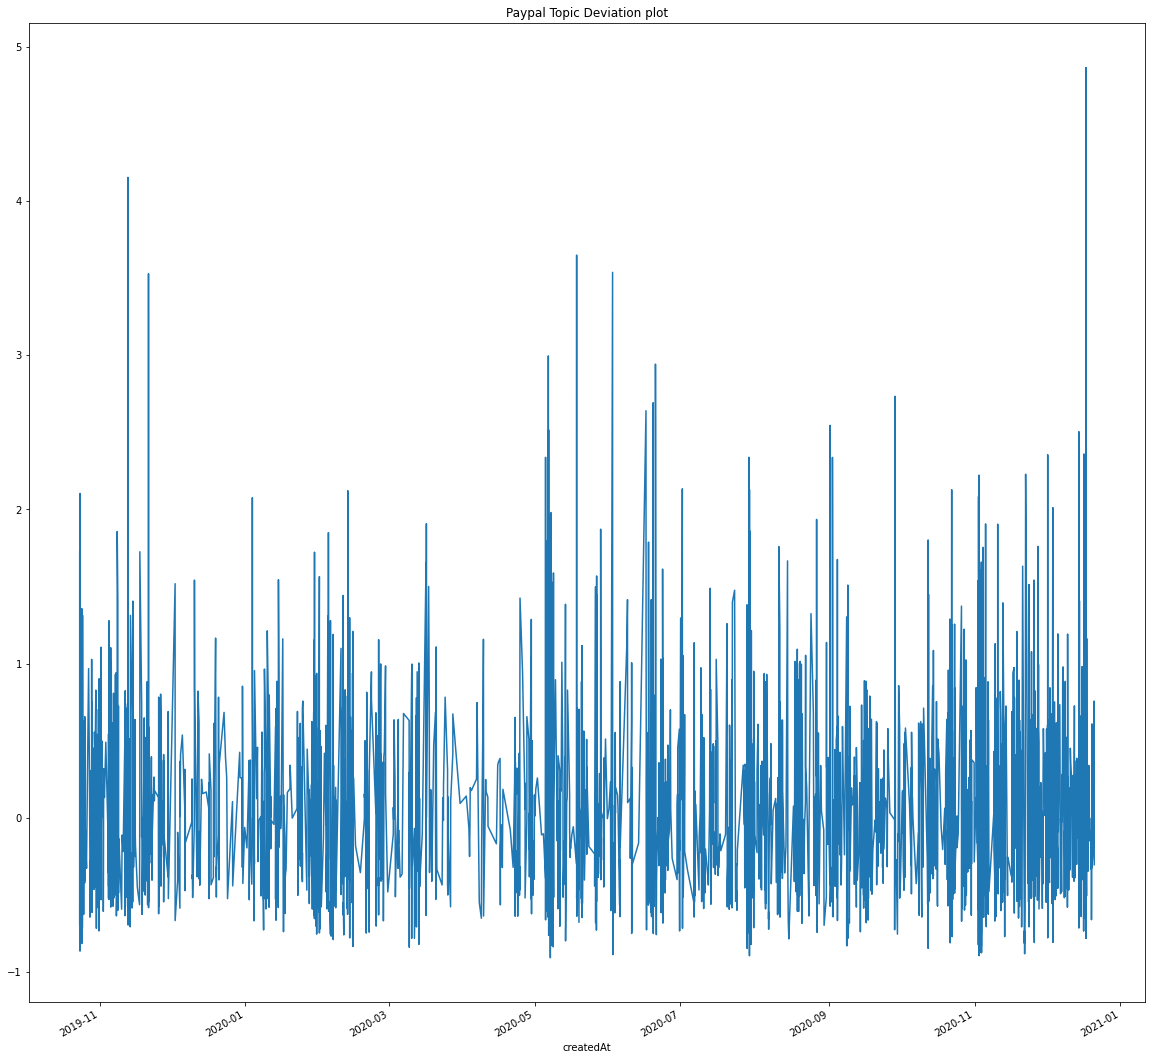

In [180]:
full_corpus.loc[(full_corpus.Comp == 'pypl') & (full_corpus.message != 'n')].iloc[-5000:].plot(x='createdAt', y='deviation', title ='Paypal Topic Deviation plot', legend =False, figsize=(20,20))

In [181]:
pypl = full_corpus.loc[(full_corpus.Comp == 'pypl') & (full_corpus.message != 'n')].iloc[-5000:]

In [183]:
fig = px.line(df, x="createdAt", y="deviation", title="layout.hovermode='x'")
fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x")

fig.show()

'short the close today and cover at open in the am for a 10 buck gain per share.'

In [192]:
import plotly.io as pio
pio.renderers.default='notebook'

In [194]:
full_corpus.to_csv("full_corpus.csv")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

In [4]:
np.random.seed(123)
data = sim_randomwalk(n_series=10, timesteps=200, 
                      process_noise=10, measure_noise=30)

In [9]:
smoother = ExponentialSmoother(window_len=20, alpha=0.3)
smoother.smooth(data[0,:])

<tsmoothie.smoother.ExponentialSmoother>

In [11]:
smoother.smooth_data.shape

(1, 180)

In [ ]:
def dev_from_start(df, comp, embs): 
    our_df = df.loc[(df.Comp == comp) & (df.t2v != 'n')]
    inds = our_df.index.values
    nd = embs.shape[1]
    # get first average of first 10 messages for starting point
    firstInds = inds[:10]
    start_vec = np.zeros(nd)
    for i in firstInds:
        start_vec += embs[i, :]
    start_vec /= 10
    
    dists = []
    dates = []
    
    for i in inds[10:]:
        dist_vec = embs[i,:] - start_vec
        dists.append(np.linalg.norm(dist_vec))
        dates.append(df['createdAt'].iloc[i])
    
    plt.plot (dates, dists)
    
def dev_from_main(df, comp, embs, t_vecs, mod = 'top_Ng'):
    our_df = df.loc[(df.Comp == comp) & (df.t2v != 'n')]
    main_top = find_main_topic(df, comp, mod)
    main_top_vec = t_vecs[main_top, :]
    
    nTops = t_vecs.shape[0]
    main_vec = t_vecs[main_top, :]
    dist_dict = {}
    dist_dict[-1] = 0
    for i in range(nTops):
        cur_top = t_vecs[i, :]
        similarity = np.linalg.norm(cur_top - main_vec)
        dist_dict[i] = similarity
    

    dists = our_df[mod].apply(lambda x: dist_dict[x])
    
    # getting index score
    dists_norm = [(d - min(dists))/(max(dists)-min(dists)) for d in dists]
    score = np.mean(dists_norm)
    print(score)
    plt.plot(our_df.createdAt.values, dists)

In [1]:
import numpy as np

In [8]:
teams = ['France', 'Holland', 'Belgium', 'England', 'Portugal', 'Spain', 'Germany']
mandem = ['Sal', 'Peter', 'Hej', 'James', 'Harry', 'Frank', 'Dylan']

perms = np.random.permutation(7)

for i in range(7):
    print("{}: {}".format(mandem[i], teams[perms[i]]))

Sal: England
Peter: Belgium
Hej: Spain
James: Portugal
Harry: Germany
Frank: France
Dylan: Holland
